In [0]:
from openfermion.transforms import get_fermion_operator, jordan_wigner,get_sparse_operator
from openfermion.hamiltonians import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
from pyscf import fci
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import QuantumCircuit,execute,Aer,IBMQ,QuantumRegister

In [0]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.977
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

hamiltonian_matrix=get_sparse_operator(jw_hamiltonian)

In [0]:
depth=n_qubit

def he_ansatz_circuit(n_qubit, depth, theta_list):
    q=QuantumRegister(n_qubit)
    circuit = QuantumCircuit(q)
    for d in range(depth):
        for i in range(n_qubit):
            circuit.ry(-theta_list[2*i+2*n_qubit*d],q[i])
            circuit.rz(-theta_list[2*i+1+2*n_qubit*d],q[i])
        for i in range(n_qubit//2):
            circuit.cz(q[2*i],q[2*i+1])
        for i in range(n_qubit//2-1):
            circuit.cz(q[2*i+1],q[2*i+2])
    for i in range(n_qubit):
        circuit.ry(theta_list[2*i+2*n_qubit*depth],q[i])
        circuit.rz(theta_list[2*i+1+2*n_qubit*depth],q[i])
    return circuit

In [0]:
def cost(theta_list):
    circuit=he_ansatz_circuit(n_qubit, depth, theta_list)
    backend=Aer.get_backend("statevector_simulator")
    state=execute(circuit,backend).result().get_statevector()
    cost=np.array([state]).conj()@hamiltonian_matrix@np.array([state]).T
    return np.real(cost[0,0])

In [0]:
cost_history = []
init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list, method=method,
               callback=lambda x: cost_history.append(cost(x)))

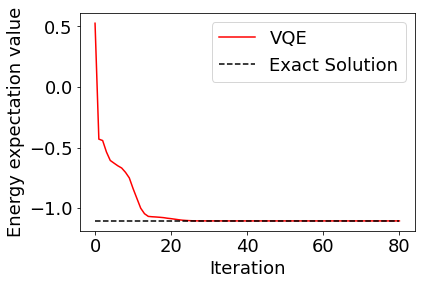

In [0]:
plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [molecule.fci_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()